# Определение стоимости автомобилей

## Подготовка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
len(df.query("Price < 1"))

10772

In [6]:
df = df.query("Price > 1")

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Удаим строки с нулевой ценой, так как это похоже на ошибки.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342408 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        342408 non-null  object
 1   Price              342408 non-null  int64 
 2   VehicleType        309126 non-null  object
 3   RegistrationYear   342408 non-null  int64 
 4   Gearbox            325424 non-null  object
 5   Power              342408 non-null  int64 
 6   Model              325140 non-null  object
 7   Kilometer          342408 non-null  int64 
 8   RegistrationMonth  342408 non-null  int64 
 9   FuelType           313389 non-null  object
 10  Brand              342408 non-null  object
 11  NotRepaired        277177 non-null  object
 12  DateCreated        342408 non-null  object
 13  NumberOfPictures   342408 non-null  int64 
 14  PostalCode         342408 non-null  int64 
 15  LastSeen           342408 non-null  object
dtypes: int64(7), object(

In [9]:
# проверим есть ли вообще анкеты с фотографиями 


df["NumberOfPictures"].sum()

0

Везьде по нулям, эти данные загрузились неправильно. Сообщим об этом коллегам для доработок.

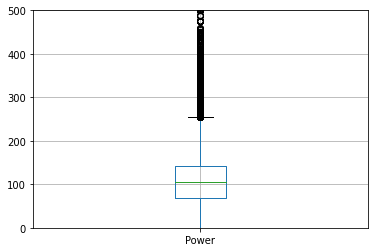

In [10]:
# проверим выбросы в столбце цены авто


ax = df.boxplot(column='Power')
ax.set_ylim(0, 500)
plt.show()

In [11]:
# посмотрим сколько авто с подозрительно малой мощьностью


len(df.query('Power < 20'))

36271

Многовато

In [12]:
# Сколько из них не поедут


len(df.query('Power < 1'))

35877

Теперь понятно

In [13]:
# удалим строки с нулевой мощностью, так как это похоже на ошибки

df = df.query('Power > 1').reset_index()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306506 entries, 0 to 306505
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              306506 non-null  int64 
 1   DateCrawled        306506 non-null  object
 2   Price              306506 non-null  int64 
 3   VehicleType        285282 non-null  object
 4   RegistrationYear   306506 non-null  int64 
 5   Gearbox            300458 non-null  object
 6   Power              306506 non-null  int64 
 7   Model              294103 non-null  object
 8   Kilometer          306506 non-null  int64 
 9   RegistrationMonth  306506 non-null  int64 
 10  FuelType           286839 non-null  object
 11  Brand              306506 non-null  object
 12  NotRepaired        259575 non-null  object
 13  DateCreated        306506 non-null  object
 14  NumberOfPictures   306506 non-null  int64 
 15  PostalCode         306506 non-null  int64 
 16  LastSeen           3

In [15]:
# посмотрим сколько авто с подозрительно большой мощьностью

len(df.query('Power > 500 '))

423

Людям с дорогими авто тоже нужно определять их рыночную цену. Оставим эти данные

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306506 entries, 0 to 306505
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              306506 non-null  int64 
 1   DateCrawled        306506 non-null  object
 2   Price              306506 non-null  int64 
 3   VehicleType        285282 non-null  object
 4   RegistrationYear   306506 non-null  int64 
 5   Gearbox            300458 non-null  object
 6   Power              306506 non-null  int64 
 7   Model              294103 non-null  object
 8   Kilometer          306506 non-null  int64 
 9   RegistrationMonth  306506 non-null  int64 
 10  FuelType           286839 non-null  object
 11  Brand              306506 non-null  object
 12  NotRepaired        259575 non-null  object
 13  DateCreated        306506 non-null  object
 14  NumberOfPictures   306506 non-null  int64 
 15  PostalCode         306506 non-null  int64 
 16  LastSeen           3

In [17]:
# оставим пропуски, так как это тоже важная информация, но заменим их на другое значение, с которым будет работать модель


df = df.fillna('unknown')

In [18]:
# удалим дубликаты


df = df.drop_duplicates().reset_index(drop= True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306506 entries, 0 to 306505
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   index              306506 non-null  int64 
 1   DateCrawled        306506 non-null  object
 2   Price              306506 non-null  int64 
 3   VehicleType        306506 non-null  object
 4   RegistrationYear   306506 non-null  int64 
 5   Gearbox            306506 non-null  object
 6   Power              306506 non-null  int64 
 7   Model              306506 non-null  object
 8   Kilometer          306506 non-null  int64 
 9   RegistrationMonth  306506 non-null  int64 
 10  FuelType           306506 non-null  object
 11  Brand              306506 non-null  object
 12  NotRepaired        306506 non-null  object
 13  DateCreated        306506 non-null  object
 14  NumberOfPictures   306506 non-null  int64 
 15  PostalCode         306506 non-null  int64 
 16  LastSeen           3

## Обучение моделей

In [20]:
# удаим не нужные столбцы (c коичеством фотографий, индексом почты и тд.)
# и создадим еще одну таблицу для модели градиентного бустинга

df_new = df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1)
df_cat = df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1)

In [21]:
enc = OrdinalEncoder()
df_new[['VehicleType','Gearbox','Model','FuelType','Brand' ,'NotRepaired']] = enc.fit_transform(df_new[['VehicleType','Gearbox','Model','FuelType','Brand' ,'NotRepaired']])

In [22]:
df_new.head()

,index,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,1,18300,2.0,2011,1.0,190,227.0,125000,5,2.0,1.0,2.0
1,2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
2,3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0
3,4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
4,5,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,2.0


In [23]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306506 entries, 0 to 306505
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              306506 non-null  int64  
 1   Price              306506 non-null  int64  
 2   VehicleType        306506 non-null  float64
 3   RegistrationYear   306506 non-null  int64  
 4   Gearbox            306506 non-null  float64
 5   Power              306506 non-null  int64  
 6   Model              306506 non-null  float64
 7   Kilometer          306506 non-null  int64  
 8   RegistrationMonth  306506 non-null  int64  
 9   FuelType           306506 non-null  float64
 10  Brand              306506 non-null  float64
 11  NotRepaired        306506 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 28.1 MB


In [24]:
# создадим обучающую и валидацинные выборки 


features = df_new.drop(['Price'], axis=1)
target = df_new['Price']

In [25]:
features.shape

(306506, 11)

In [26]:
target.shape

(306506,)

In [27]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [28]:
features_train.shape

(229879, 11)

In [29]:
features_valid.shape

(76627, 11)

In [30]:
#target_train = np.array(target_train)
target_train.shape

(229879,)

In [31]:
#target_valid = np.array(target_valid)
target_valid.shape

(76627,)

In [32]:
features_train.head()

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
92968,107609,7.0,1995,1.0,75,42.0,150000,0,6.0,24.0,0.0
81702,94613,5.0,1999,1.0,45,5.0,150000,6,6.0,25.0,1.0
240328,277737,1.0,1979,1.0,90,199.0,100000,6,6.0,38.0,0.0
135446,156635,7.0,2009,1.0,68,46.0,125000,0,6.0,36.0,1.0
195475,226078,0.0,2011,1.0,109,212.0,150000,4,2.0,20.0,0.0


In [33]:
# создадим таблицу в которую будем заносить результаты моделей

models_rating=[]

In [34]:
# проверим модель решающего дерева


start_1 = time.time()

model = DecisionTreeRegressor(random_state=0)
 
model.fit(features_train,target_train)

end_1 = time.time()

In [35]:
start_2 = time.time()
predictions = model.predict(features_valid) 
end_2 = time.time()

mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print("rmse модели:", rmse)

rmse модели: 2212.8190602791988


In [36]:
def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

In [37]:
# добавим резуьтаты первой модели


models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

In [38]:
models_rating

[{'model name': 'DecisionTreeRegressor',
  'rmse модели': 2212.8190602791988,
  'время обучения,c': '1.82',
  'время предсказания,c': '0.06'}]

In [39]:
# проверим модель линейной регрессии



model = LinearRegression()

start_1 = time.time()
model.fit(features_train,target_train) 
end_1 = time.time()

In [40]:
start_2 = time.time()
predictions = model.predict(features_valid) 
end_2 = time.time()

mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print("rmse модели:", rmse)

rmse модели: 3610.335710335028


In [41]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

Результат хуже чем у дерева решений.

In [42]:
# проверим модель рандомного леса


model = RandomForestRegressor(random_state=0)
start_1 = time.time()
model.fit(features_train,target_train) 
end_1 = time.time()

In [43]:
start_2 = time.time()
predictions = model.predict(features_valid) 
end_2 = time.time()


mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print("rmse модели:", rmse)

rmse модели: 1622.715842521034


In [44]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

Имеем пока лучший результат в 1622 со временем обучения: 1м 23с, и временем предсказания: 4.5с.

In [45]:
# создадим обучающую выборку без кодирования категориальных признаков 


CatBoost_features = df_cat.drop(['Price'], axis=1)
CatBoost_target = df_cat['Price']

features_train_CatBoost, features_valid_CatBoost, target_train_CatBoost, target_valid_CatBoost = train_test_split(
    CatBoost_features, CatBoost_target, test_size=0.25, random_state=12345)

In [46]:
CatBoost_features.head()

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,1,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
1,2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
2,3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
3,4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
4,5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [47]:
CatBoost_target.dtype

dtype('int64')

In [48]:
# обучим CatBoost бустинг без подбора параметров




cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']


model = CatBoostRegressor(loss_function='RMSE', iterations =10, verbose=False,random_state=0)

start_1 = time.time()
model.fit(features_train_CatBoost, target_train_CatBoost, cat_features=cat_features)
end_1 = time.time()

In [49]:
start_2 = time.time()
predictions = model.predict(features_valid_CatBoost) 
end_2 = time.time()


mse = mean_squared_error(target_valid_CatBoost, predictions)
rmse = mse ** 0.5
print("rmse модели:", rmse)

rmse модели: 1936.576605587318


In [50]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)})  

Здесь результат лучше дерева решений -  1936.

In [51]:
# обучим LGBM бустинг без подбора параметров



start_1 = time.time()
model = LGBMRegressor(random_state=0 )
model.fit(features_train, target_train)
end_1 = time.time()

In [52]:
# получим предсказания и проверим метрику


start_2 = time.time()
predictions = model.predict(features_valid)
end_2 = time.time()

mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print("rmse модели:", rmse)

rmse модели: 1720.3661487336983


In [53]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

Этот бустинг дал результат лучше лучше модели CatBoostRegressor  -  1720.

In [54]:
# теперь подберем параметры для бустинга, сравним результаты






estimator = LGBMRegressor(num_leaves=10,max_depth =3)

param_grid = {

    'learning_rate': [0.01, 0.1],

    'n_estimators': [30, 50]

}
def rmse(actual, predict):

    mse = mean_squared_error(actual, predict)
    rmse = mse ** 0.5
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)


gbm = GridSearchCV(estimator, param_grid,scoring=rmse_score)

gbm.fit(features_train, target_train)

print('Лучшие параметры:', gbm.best_params_)

Лучшие параметры: {'learning_rate': 0.01, 'n_estimators': 30}


Мы подобрали лучшие параметры для этой модели.

In [55]:
# обучим модель с подобранными параметрами



start_1 = time.time()
model = LGBMRegressor(num_leaves=10,max_depth =3,learning_rate=0.1,n_estimators=30)
model.fit(features_train, target_train)
end_1 = time.time()

In [56]:
# получим предсказания и проверим метрику


start_2 = time.time()
predictions = model.predict(features_valid)
end_2 = time.time()

mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print("rmse модели:", rmse)

rmse модели: 2253.8445694770285


In [57]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

Тут у нас не лучший результат в 2253. Результат ухудшился, было 1720.

In [58]:
# подберем параметры для CatBoost бустинга




estimator = CatBoostRegressor(verbose=False)

param_grid = {

    'learning_rate': [0.1, 1],

    'n_estimators': [300,350,400]

}

gbm = GridSearchCV(estimator, param_grid,verbose=1)

gbm.fit(features_train, target_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found by grid search are: {'learning_rate': 1, 'n_estimators': 350}


Подобрали параметры для CatBoostRegressor

In [59]:
# обучим модель с подобранными параметрами


start_1 = time.time()
model = CatBoostRegressor(learning_rate=1,n_estimators=350,verbose=False)
model.fit(features_train, target_train)
end_1 = time.time()

In [60]:
# получим предсказания и проверим метрику


start_2 = time.time()
predictions = model.predict(features_valid)
end_2 = time.time()

mse = mean_squared_error(target_valid, predictions)
rmse = mse ** 0.5
print("rmse модели:", rmse)

rmse модели: 1668.9727577824292


In [61]:
models_rating.append({'model name': model.__class__.__name__, 
                              'rmse модели': rmse, 
                              'время обучения,c': toFixed(end_1 - start_1,2),
                              'время предсказания,c':toFixed(end_2 - start_2,2)}) 

В результате имеем метрику в 1822 при времени обучения 5 с и предсказания 1 с соотвецтвенно. Результат улучшился после подбора параметров. Было 2044.

## Анализ моделей

In [62]:
pd.DataFrame(models_rating).sort_values(by=['rmse модели'])

,model name,rmse модели,"время обучения,c","время предсказания,c"
2,RandomForestRegressor,1622.715843,110.43,4.27
6,CatBoostRegressor,1668.972758,12.79,0.04
4,LGBMRegressor,1720.366149,374.37,0.61
3,CatBoostRegressor,1936.576606,2.16,0.08
0,DecisionTreeRegressor,2212.819060,1.82,0.06
5,LGBMRegressor,2253.844569,1.31,0.10
1,LinearRegression,3610.335710,0.08,0.11


Тройка лидеров по результату метрики:


- RandomForestRegressor : 1622 (обучение:130с, предсказание:4.5с)
- CatBoostRegressor : 1668 (обучение:22с, предсказание:<1)
- LGBMRegressor : 1720 (обучение:7c, предсказание:<1)


Можно сделать вывод, что при требовании наилучшей метрики целесообразно выбрать RandomForestRegressor.

А для баланса в свою очередь стоит использовать CatBoostRegressor, если требуется быстрое обучение.

Сообщить коллегам что данные о фото не загрузились.